<h1>Distributed Federated Learning with MNIST Data</h1>

<b>Importing the libraries</b>

<ul>
<li> Pytorch (to train the model)
<li> Pysyft (to train using federated approach)
</ul>

In [1]:
import pickle
import itertools
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import syft as sy
from syft.frameworks.torch.fl import utils
import pandas as pd
import itertools
import random

In [2]:
class Parser:
     def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 30
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 30
        self.save_model = False
        self.num_of_workers = 3
    
args = Parser()
torch.manual_seed(args.seed)
kwargs = {'num_workers': 1, 'pin_memory': False}

<b>Download MNIST Data using torchvision datasets module</b>

In [3]:
train_loader = DataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    #.federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=args.batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

<b>Creating architecture of the Neural Network model</b>

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def federated_avg(self, neighbour_model_params=None, current_worker=None):
        #Average two models weights
        
        params1 = self.state_dict()
        params2 = neighbour_model_params.copy()
      
        with torch.no_grad():
            for name1 in params1:
                if name1 in params2:
                    neighbour_ptr = params2[name1].copy()
                    neighbour_ptr.move(current_worker)
                    #print(current_worker, neighbour_ptr)
                    params1[name1] = (params1[name1]  + neighbour_ptr)/2
        
                    
        self.load_state_dict(params1, strict=False)
        
    

In [5]:
#Create events list for virutal workers exchange of parameters.
def create_events(num_of_workers):
    worker_events = list(itertools.combinations(range(1,num_of_workers+1),2))
    random.shuffle(worker_events)
    
    events_df = pd.DataFrame(worker_events,columns=['worker_id1','worker_id2'])
    events_df.index.names = ["batchnum"]
    return events_df

In [6]:
events_df = create_events(args.num_of_workers)
events_df

,worker_id1,worker_id2
batchnum,,
0,1,2
1,1,3
2,2,3


<b>Initilizer Function to create Virtual workers, initiate models and optimizers. Data will split amongst workers and trained.</b>

In [7]:
def initialize_workers():
    hook = sy.TorchHook(torch)
    compute_nodes = [sy.VirtualWorker(hook, id=f"worker-{i}") for i in range(args.num_of_workers)]
    remote_dataset = tuple(list() for _ in range(args.num_of_workers))
    train_distributed_dataset = []

    for batch_idx, (data,target) in enumerate(train_loader):
        data = data.send(compute_nodes[batch_idx % len(compute_nodes)])
        target = target.send(compute_nodes[batch_idx % len(compute_nodes)])
        remote_dataset[batch_idx % len(compute_nodes)].append((data, target))
        
    models = [Net() for _ in range(args.num_of_workers)]
    optimizers = [optim.SGD(models[i].parameters(), lr=args.lr) for i in range(args.num_of_workers)]
    return compute_nodes, remote_dataset, models, optimizers


In [8]:
def update(data, target, model, optimizer):
    model.send(data.location)
    #print(model, data)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    return model

In [9]:
def exchange_parameters(models, data_index):
    #Get the workers ID from event dataframe to exchange parameters between two worker models.
    event_idx = data_index % len(events_df)
    event_row = events_df.loc[[event_idx]]
    worker_id1 = event_row['worker_id1'].values[0]-1
    worker_id2 = event_row['worker_id2'].values[0]-1
    worker1_model = models[worker_id1]
    worker2_model = models[worker_id2]
    worker1_params = worker1_model.state_dict()
    worker2_params = worker2_model.state_dict()
    
    #Send worker2 params to worker1 for averaging at worker1
    worker1_model.federated_avg(worker2_params, compute_nodes[worker_id1])
    
    #Send worker1 params to worker2 for averaging at worker2
    worker2_model.federated_avg(worker1_params, compute_nodes[worker_id2])

In [10]:
def train(models, compute_nodes, remote_dataset, optimizers, federated_average=False, exchange=False):
    
    if federated_average:
        models = [models.copy() for _ in range(args.num_of_workers)]
        optimizers = [optim.SGD(models[i].parameters(), lr=args.lr) for i in range(args.num_of_workers)]
        
    for data_index in range(len(remote_dataset[0])-1):
        #print(f"Trip {data_index} and length of remote_dataset in {len(remote_dataset[0])} {len(remote_dataset[1])} {len(remote_dataset[2])}")
        for remote_index in range(len(compute_nodes)):
            data, target = remote_dataset[remote_index][data_index]
            models[remote_index] = update(data, target, models[remote_index], optimizers[remote_index])
        
        #Exchange of parameter between two remote models.
        if exchange:
            exchange_parameters(models, data_index)
        
        for model in models:
            model.get()
        
        
    #Federated Average
    if federated_average:
        model =  utils.federated_avg({f"worker-{i}":models[i] for i in range(len(compute_nodes))})
        return model

In [11]:
def test(federated_model, worker_id):
    federated_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = federated_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            prediction = output.argmax(1, keepdim=True)
            correct += prediction.eq(target.view_as(prediction)).sum().item()
           
        
    test_loss /= len(test_loader.dataset)
    avg_correct = correct / len(test_loader.dataset)
    print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format(worker_id, test_loss, avg_correct))
    return test_loss, avg_correct
    

In [12]:
def run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, exchange=False):
    model = Net()
    
    eval_results = []
    for epoch in range(args.epochs):
        start_time = time.time()
        print(f"Epoch Number {epoch + 1}")
        

        if not federated_average:
            train(models, compute_nodes, remote_dataset, optimizers, federated_average, exchange)
            for worker_node, worker_model in zip(compute_nodes, models):
                avg_loss, avg_accuracy = test(worker_model, worker_node.id)
                results = {"worker_id" : worker_node.id,
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
                eval_results.append(results)
        else:
            
            federated_model = train(model, compute_nodes, remote_dataset, optimizers, federated_average, exchange)
            avg_loss, avg_accuracy = test(federated_model, "federated_avg_local")
            results = {"worker_id" : "federated_avg_local",
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
            eval_results.append(results)
            model = federated_model
            
        total_time = time.time() - start_time
        print('Communication time over the network', round(total_time, 2), 's\n')
    return eval_results

###  Simulation with training on individual workers on their local data

In [13]:
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
individual_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, exchange=False)
    #
    
    

Epoch Number 1
Test set for worker worker-0: Average loss: 0.3721 & Average Accuracy : 0.8889
Test set for worker worker-1: Average loss: 0.3341 & Average Accuracy : 0.9052
Test set for worker worker-2: Average loss: 0.3302 & Average Accuracy : 0.8998
Communication time over the network 132.44 s

Epoch Number 2
Test set for worker worker-0: Average loss: 0.2342 & Average Accuracy : 0.9300
Test set for worker worker-1: Average loss: 0.2236 & Average Accuracy : 0.9384
Test set for worker worker-2: Average loss: 0.2273 & Average Accuracy : 0.9311
Communication time over the network 134.84 s

Epoch Number 3
Test set for worker worker-0: Average loss: 0.1723 & Average Accuracy : 0.9486
Test set for worker worker-1: Average loss: 0.1678 & Average Accuracy : 0.9527
Test set for worker worker-2: Average loss: 0.1717 & Average Accuracy : 0.9489
Communication time over the network 135.08 s

Epoch Number 4
Test set for worker worker-0: Average loss: 0.1367 & Average Accuracy : 0.9594
Test set for

Test set for worker worker-2: Average loss: 0.0556 & Average Accuracy : 0.9829
Communication time over the network 135.77 s

Epoch Number 29
Test set for worker worker-0: Average loss: 0.0466 & Average Accuracy : 0.9864
Test set for worker worker-1: Average loss: 0.0497 & Average Accuracy : 0.9842
Test set for worker worker-2: Average loss: 0.0545 & Average Accuracy : 0.9831
Communication time over the network 137.3 s

Epoch Number 30
Test set for worker worker-0: Average loss: 0.0467 & Average Accuracy : 0.9863
Test set for worker worker-1: Average loss: 0.0496 & Average Accuracy : 0.9840
Test set for worker worker-2: Average loss: 0.0539 & Average Accuracy : 0.9835
Communication time over the network 136.44 s



###  Simulation with training  with federated average

In [14]:
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
fedavg_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=True, exchange=False)
    #

Epoch Number 1
Test set for worker federated_avg_local: Average loss: 0.3125 & Average Accuracy : 0.9122
Communication time over the network 129.07 s

Epoch Number 2
Test set for worker federated_avg_local: Average loss: 0.2125 & Average Accuracy : 0.9349
Communication time over the network 128.77 s

Epoch Number 3
Test set for worker federated_avg_local: Average loss: 0.1616 & Average Accuracy : 0.9525
Communication time over the network 129.95 s

Epoch Number 4
Test set for worker federated_avg_local: Average loss: 0.1297 & Average Accuracy : 0.9617
Communication time over the network 129.18 s

Epoch Number 5
Test set for worker federated_avg_local: Average loss: 0.1087 & Average Accuracy : 0.9681
Communication time over the network 129.9 s

Epoch Number 6
Test set for worker federated_avg_local: Average loss: 0.0941 & Average Accuracy : 0.9711
Communication time over the network 142.9 s

Epoch Number 7
Test set for worker federated_avg_local: Average loss: 0.0831 & Average Accuracy 

###  Simulation with training  with Decentralized federated average

In [15]:
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
decentrailized_fedavg_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, exchange=True)

Epoch Number 1
Test set for worker worker-0: Average loss: 0.8142 & Average Accuracy : 0.7459
Test set for worker worker-1: Average loss: 0.7674 & Average Accuracy : 0.8183
Test set for worker worker-2: Average loss: 0.7696 & Average Accuracy : 0.8132
Communication time over the network 159.38 s

Epoch Number 2
Test set for worker worker-0: Average loss: 0.3476 & Average Accuracy : 0.8927
Test set for worker worker-1: Average loss: 0.3144 & Average Accuracy : 0.9059
Test set for worker worker-2: Average loss: 0.3174 & Average Accuracy : 0.9069
Communication time over the network 158.38 s

Epoch Number 3
Test set for worker worker-0: Average loss: 0.2415 & Average Accuracy : 0.9266
Test set for worker worker-1: Average loss: 0.2209 & Average Accuracy : 0.9354
Test set for worker worker-2: Average loss: 0.2263 & Average Accuracy : 0.9332
Communication time over the network 158.63 s

Epoch Number 4
Test set for worker worker-0: Average loss: 0.1851 & Average Accuracy : 0.9459
Test set for

Test set for worker worker-2: Average loss: 0.0416 & Average Accuracy : 0.9860
Communication time over the network 169.44 s

Epoch Number 29
Test set for worker worker-0: Average loss: 0.0399 & Average Accuracy : 0.9875
Test set for worker worker-1: Average loss: 0.0399 & Average Accuracy : 0.9871
Test set for worker worker-2: Average loss: 0.0410 & Average Accuracy : 0.9862
Communication time over the network 171.57 s

Epoch Number 30
Test set for worker worker-0: Average loss: 0.0394 & Average Accuracy : 0.9876
Test set for worker worker-1: Average loss: 0.0393 & Average Accuracy : 0.9872
Test set for worker worker-2: Average loss: 0.0404 & Average Accuracy : 0.9865
Communication time over the network 179.63 s



In [16]:
ind_train_df = pd.DataFrame(individual_train_results)
ind_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,worker-0,0,0.372081,0.8889
1,worker-1,0,0.334090,0.9052
2,worker-2,0,0.330227,0.8998
3,worker-0,1,0.234168,0.9300
4,worker-1,1,0.223624,0.9384
...,...,...,...,...
85,worker-1,28,0.049744,0.9842
86,worker-2,28,0.054479,0.9831
87,worker-0,29,0.046668,0.9863
88,worker-1,29,0.049559,0.9840


In [17]:
fedavg_train_df = pd.DataFrame(fedavg_train_results)
fedavg_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,federated_avg_local,0,0.312530,0.9122
1,federated_avg_local,1,0.212500,0.9349
2,federated_avg_local,2,0.161605,0.9525
3,federated_avg_local,3,0.129706,0.9617
4,federated_avg_local,4,0.108704,0.9681
5,federated_avg_local,5,0.094076,0.9711
6,federated_avg_local,6,0.083089,0.9741
7,federated_avg_local,7,0.074768,0.9772
8,federated_avg_local,8,0.068359,0.9792
9,federated_avg_local,9,0.063275,0.9808


In [18]:
decentrailized_fedavg_train_df = pd.DataFrame(decentrailized_fedavg_train_results)
decentrailized_fedavg_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,worker-0,0,0.814239,0.7459
1,worker-1,0,0.767434,0.8183
2,worker-2,0,0.769607,0.8132
3,worker-0,1,0.347588,0.8927
4,worker-1,1,0.314388,0.9059
...,...,...,...,...
85,worker-1,28,0.039851,0.9871
86,worker-2,28,0.041038,0.9862
87,worker-0,29,0.039364,0.9876
88,worker-1,29,0.039285,0.9872


### Plot Graph for Individual worker training accuracy over time.

In [19]:
#%matplotlib inline
#for key, grp in ind_train_df.groupby(['worker_id']):
#    grp.plot(x="epoch_idx", y="avg_accuracy", label=key, ylabel="avg_accuracy")



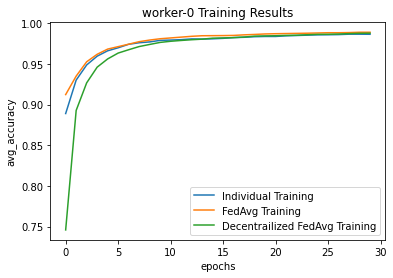

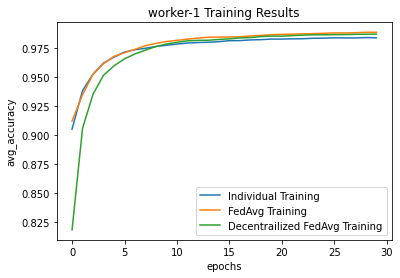

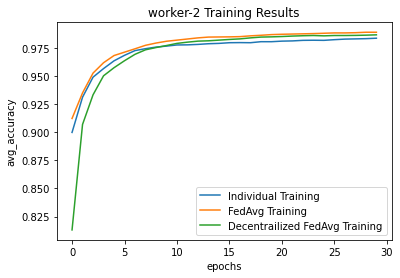

In [20]:
%matplotlib inline
ind_train_df
fedavg_train_df
decentrailized_fedavg_train_df
for node in compute_nodes:
    ind_worker_data  = ind_train_df[ind_train_df['worker_id']==node.id]
    plt.plot(ind_worker_data['epoch_idx'],ind_worker_data['avg_accuracy'], label="Individual Training")

    plt.plot(fedavg_train_df['epoch_idx'],fedavg_train_df['avg_accuracy'], label="FedAvg Training")
    
    decentral_worker_data  = decentrailized_fedavg_train_df[decentrailized_fedavg_train_df['worker_id']==node.id]
    plt.plot(decentral_worker_data['epoch_idx'],decentral_worker_data['avg_accuracy'], label="Decentrailized FedAvg Training")
    
    plt.xlabel('epochs')
    # Set the y axis label of the current axis.
    plt.ylabel('avg_accuracy')
    # Set a title of the current axes.
    plt.title(f'{node.id} Training Results')
    # show a legend on the plot
    plt.legend()
    # Display a figure.
    plt.show()